# Multivariate Linear Regression

INFO:tensorflow:Summary name cost J is illegal; using cost_J instead.
iteration = 1 cost_function =  8.94662e+10
iteration = 2 cost_function =  6.27671e+10
iteration = 3 cost_function =  4.56799e+10
iteration = 4 cost_function =  3.47439e+10
iteration = 5 cost_function =  2.77449e+10
iteration = 6 cost_function =  2.32656e+10
iteration = 7 cost_function =  2.03988e+10
iteration = 8 cost_function =  1.85641e+10
iteration = 9 cost_function =  1.73898e+10
iteration = 10 cost_function =  1.66383e+10
iteration = 11 cost_function =  1.61574e+10
iteration = 12 cost_function =  1.58495e+10
iteration = 13 cost_function =  1.56525e+10
iteration = 14 cost_function =  1.55265e+10
iteration = 15 cost_function =  1.54458e+10
iteration = 16 cost_function =  1.53941e+10
iteration = 17 cost_function =  1.53611e+10
iteration = 18 cost_function =  1.53399e+10
iteration = 19 cost_function =  1.53264e+10
iteration = 20 cost_function =  1.53177e+10
iteration = 21 cost_function =  1.53122e+10
iteration = 22 

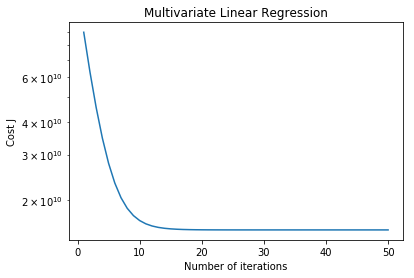

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


def readcsvfile(filename, param_record_defaults, batch_size, num_epochs, shuffle):
    min_after_dequeue = 10000
    capacity = min_after_dequeue + 3 * batch_size

    filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs, shuffle=shuffle)

    reader = tf.TextLineReader()
    key, value = reader.read(filename_queue)

    features = tf.stack(tf.decode_csv(value, record_defaults=param_record_defaults))

    if True == shuffle:
        features_batch = tf.train.shuffle_batch([features],
                                                batch_size=batch_size, capacity=capacity,
                                                min_after_dequeue=min_after_dequeue)
    else:
        features_batch = tf.train.batch([features],
                                        batch_size=batch_size, capacity=capacity)

    return features_batch


def addBiasTerm(X):
    m = np.size(X, 0)
    n = np.size(X, 1)
    X_bias = np.ones([m, n + 1])

    for i in range(m):
        for j in range(n):
            X_bias[i, j + 1] = X[i, j]

    return X_bias


def featureNormalization(X):
    m = np.size(X, 0)
    n = np.size(X, 1)

    mu = np.zeros([n])  # x1, x2
    sigma = np.zeros([n])
    X_norm = X

    tol = 1e-10

    for j in range(n):
        mu[j] = np.mean(X_norm[:, j])
        sigma[j] = np.std(X_norm[:, j])

        # Avoid zero variance issue
        if sigma[j] <= tol:
            sigma[j] = 1

        for i in range(m):
            X_norm[i, j] = (X_norm[i, j] - mu[j]) / sigma[j]

    return X_norm, mu, sigma


record_defaults = [tf.constant([1], dtype=tf.float32),
                   tf.constant([1], dtype=tf.float32),
                   tf.constant([1], dtype=tf.float32)]

# Hyper parameters
batch_size = 47
max_iter = 1000000
num_of_epochs = 50
learning_rate = 0.1
hyper_lambda = 0

features = readcsvfile("C:\\Users\\Build\\Desktop\\tf\\ex1data2.csv", record_defaults, batch_size, num_of_epochs, False)

'''
 Multivariate Linear Regression

 Variables, m training set
 theta = 1 x 3
 X = m x 3
 y = m x 1

 hypothesis = theta.transpose * X[i, :]  i th data of m training set

'''
theta = tf.Variable([tf.random_uniform([1], -0.5, 0.5), tf.random_uniform([1], -0.5, 0.5), tf.random_uniform([1], -0.5, 0.5)])  # 3 x 1
X = tf.placeholder(tf.float32, [batch_size, 3])  # m x 3
y = tf.placeholder(tf.float32, [batch_size, ])  # m x 1

hypothesis = tf.matmul(X, theta)
cost_function = tf.reduce_mean(tf.square(hypothesis - y)) + hyper_lambda*tf.reduce_mean(tf.square(theta))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost_function)

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

# for matplot
iter_history = np.zeros([max_iter])
cost_history =  np.zeros([max_iter])

# for Tensor Board
tb_cost_function = tf.summary.scalar("cost J", cost_function)
tb_merged = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(init_op)

    log_dir = "./board/sample1"

    os.system("taskkill /f /im cmd.exe")

    if tf.gfile.Exists(log_dir):
        tf.gfile.DeleteRecursively(log_dir)

    writer = tf.summary.FileWriter(log_dir, sess.graph)

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # for matplot
    plt.figure(1)
    plt.title("Multivariate Linear Regression")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost J")
    plt.yscale("log")

    try:
        step = 0
        while not coord.should_stop():
            training_set = sess.run(features)

            X_data = training_set[:, 0:2]
            y_data = training_set[:, 2]

            # Mean Normalization
            X_data, mu, sigma = featureNormalization(X_data)

            # Add Bias term to data X
            X_data = addBiasTerm(X_data)

            sess.run(train, feed_dict={X: X_data, y: y_data})
            cur_cost = sess.run(cost_function, feed_dict={X: X_data, y: y_data})

            summary = sess.run(tb_merged, feed_dict={X: X_data, y: y_data})
            writer.add_summary(summary, step + 1)

            # for matplot
            iter_history[step] = step+1
            cost_history[step] = cur_cost
            print("iteration =", step + 1, "cost_function = ", cur_cost)

            step += 1

    except tf.errors.OutOfRangeError:
        print("Done -- epoch limit reached.")
        print("learning_rate=", learning_rate)
        print("batch size=", batch_size)
        print("num_of_epochs=", num_of_epochs)
        print("iterated=", step)

        print("\ntheta=", sess.run(theta))

        feed_x = tf.constant([[1, (2104 - mu[0]) / sigma[0], (3 - mu[1]) / sigma[1]]], dtype=tf.float32)
        answer = sess.run(tf.matmul(feed_x, theta))

        print(sess.run(feed_x), " => ", answer)

        # for matplot
        plt.plot(iter_history[0:step], cost_history[0:step])
        plt.show()

    finally:
        coord.request_stop()

    coord.join(threads)
    os.system("tensorboard --logdir=" + log_dir)